In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file
uploaded = files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

In [0]:
!unzip \*.zip

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img
%matplotlib inline

In [0]:
image_visulaization =ImageDataGenerator(rescale=1/255)
image_visulaization.flow_from_directory("/content/car_data/car_data/train")

In [5]:
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest",
                              validation_split=0.2) # set validation split

print(image_gen.flow_from_directory("/content/car_data/car_data/train"))
print(image_gen.flow_from_directory("/content/car_data/car_data/test"))


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [6]:
!pip install efficientnet

In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from efficientnet.keras import EfficientNetB0

In [0]:
def build_finetune_model(base_model, dropout, num_classes):
    x = base_model.output
    x = AveragePooling2D((5,5))(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation="softmax")(x)

    finetune_model = Model(inputs = base_model.input, outputs = predictions)

    return finetune_model

In [9]:
input_shape=(224,224,3)

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

finetune_model = build_finetune_model(base_model, 0.7, 196)

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

finetune_model.summary()

checkpoint_filepath = 'best_weights.h5'

my_checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,
                               verbose=1, save_best_only=True)

16809984/16804768 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
___________________________

In [10]:
batch_size = 64

train_image_gen = image_gen.flow_from_directory("/content/car_data/car_data/train",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")

valid_image_gen = image_gen.flow_from_directory("/content/car_data/car_data/test",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [11]:
result = finetune_model.fit_generator(train_image_gen,epochs=15,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=[my_checkpointer],verbose=1)

Epoch 1/15
128/128 [==============================] - 369s 3s/step - loss: 5.0871 - accuracy: 0.0312 - val_loss: 4.7353 - val_accuracy: 0.0678

Epoch 00001: val_loss improved from inf to 4.73528, saving model to best_weights.h5
Epoch 2/15
128/128 [==============================] - 333s 3s/step - loss: 3.6766 - accuracy: 0.1731 - val_loss: 3.5721 - val_accuracy: 0.2855

Epoch 00002: val_loss improved from 4.73528 to 3.57215, saving model to best_weights.h5
Epoch 3/15
128/128 [==============================] - 329s 3s/step - loss: 2.4970 - accuracy: 0.3630 - val_loss: 1.8889 - val_accuracy: 0.4564

Epoch 00003: val_loss improved from 3.57215 to 1.88890, saving model to best_weights.h5
Epoch 4/15
128/128 [==============================] - 327s 3s/step - loss: 1.7751 - accuracy: 0.5149 - val_loss: 1.5475 - val_accuracy: 0.5569

Epoch 00004: val_loss improved from 1.88890 to 1.54752, saving model to best_weights.h5
Epoch 5/15
128/128 [==============================] - 325s 3s/step - loss: 1

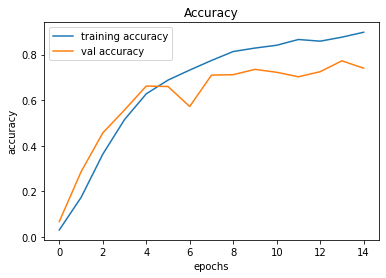

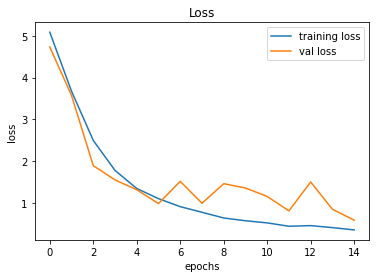

In [12]:
plt.figure(0)
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


In [0]:
finetune_model.load_weights("best_weights.h5")

In [14]:
input_shape=(224,224,3)

batch_size = 128

test_image_gen = image_gen.flow_from_directory("/content/car_data/car_data/test",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")
loss, acc = finetune_model.evaluate_generator(test_image_gen, steps=len(test_image_gen), verbose=0)
print("Accuracy on test dataset is: {}%".format(str(np.around(acc*100,2))))

Found 8041 images belonging to 196 classes.
Accuracy on test dataset is: 72.96%


In [0]:
def predict_from_image(image):
    test_image = cv2.imread(image)
    test_image = cv2.resize(test_image,(224,224))
    test_image = test_image/255
    test_image = test_image.reshape(1,224,224,3)
    
    prediction = finetune_model.predict(test_image)
        
    return np.where(prediction[0]==prediction[0].max())[0][0]

In [0]:
import pandas as pd
car_name = pd.read_csv('/content/names.csv',header=None)

/content/car_data/car_data/test/Chevrolet Corvette Convertible 2012/05365.jpg
58
Chevrolet Camaro Convertible 2012


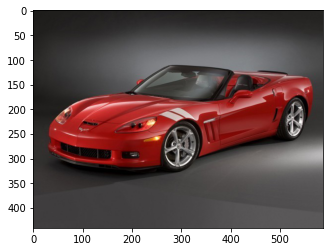

In [30]:
import glob 
test_path_folder = glob.glob("/content/car_data/car_data/test/*")
test_df = pd.DataFrame()
rand_folder = np.random.randint(len(test_path_folder))
test_path_image = glob.glob(test_path_folder[rand_folder] +"/*.jpg")

rand_image = np.random.randint(len(test_path_image))
test_image = test_path_image[rand_image]
print(test_image)

index = predict_from_image(test_image)
print(car_name[0][index])

show_image = load_img(test_image)
plt.imshow(show_image)
